Esta notebook contiene bloques de código útiles para realizar Q-learning en el entorno "Descent Env"

In [1]:
import numpy as np
from descent_env import DescentEnv
import random 
from q_learning_agent import QLearningAgent

pygame 2.5.2 (SDL 2.28.3, Python 3.10.11)
Hello from the pygame community. https://www.pygame.org/contribute.html
Using Python-based geo functions


In [2]:
# Cambiar render_mode a rgb_array para entrenar/testear
from env_recorder_wrapper import VideoRecorderWrapper 
import wandb
env = DescentEnv(render_mode='rgb_array')

Reading config from C:\Users\Agu\bluesky\settings.cfg
Reading magnetic variation data
Loading global navigation database...
Reading cache: C:\Users\Agu\bluesky\cache\navdata.p
Successfully loaded OpenAP performance model
Failed to load BADA performance model
Successfully loaded legacy performance model
Successfully loaded plugin AREA
Successfully loaded plugin DATAFEED


Observation Space

In [3]:
env.observation_space

Dict('altitude': Box(-inf, inf, (1,), float64), 'runway_distance': Box(-inf, inf, (1,), float64), 'target_altitude': Box(-inf, inf, (1,), float64), 'vz': Box(-inf, inf, (1,), float64))

Action Space

In [4]:
env.action_space

Box(-1.0, 1.0, (1,), float64)

Discretización de los estados

**Nota:** es importante que chequeen el espacio de observación y el espacio de acción del entorno. Los números usados son ejemplos y pueden no ser correctos

In [5]:
altitude_space_start = 0
altitude_space_end = 2.5
altitude_space_num = 15
altitude_space = np.linspace(altitude_space_start, altitude_space_end, altitude_space_num) 

vertical_velocity_space_start = -3
vertical_velocity_space_end = 3
vertical_velocity_space_num = 20
vertical_velocity_space = np.linspace(vertical_velocity_space_start, vertical_velocity_space_end, vertical_velocity_space_num) 

target_altitude_space_start = 0
target_altitude_space_end = 1
target_altitude_space_num = 10
target_altitude_space = np.linspace(target_altitude_space_start, target_altitude_space_end, target_altitude_space_num)

runway_distance_space_start = -1
runway_distance_space_end = 1
runway_distance_space_num = 20
runway_distance_space = np.linspace(runway_distance_space_start, runway_distance_space_end, runway_distance_space_num)


#print("altitude_space:", altitude_space)
#print("vertical_velocity_space:", vertical_velocity_space)
#print("target_altitude_space:", target_altitude_space)
#print("runway_distance_space:", runway_distance_space)


#import gymnasium as gym
#from descent_env import DescentEnv
#import numpy as np
#import random
#
#env = DescentEnv(render_mode="human") 
#obs, info = env.reset()
#
#num_episodes = 5 
#max_steps_per_episode = 500 
#
#all_altitudes = []
#all_vertical_velocities = []
#all_target_altitudes = []
#all_runway_distances = []
#
#for episode in range(num_episodes):
#    obs, info = env.reset()
#    done = False
#    steps = 0
#    print(f"\n--- Episodio {episode + 1} ---")
#    while not done and steps < max_steps_per_episode:
#        # Aquí generas una acción aleatoria válida para tu entorno
#        actions = [-1.0, -0.5, 0.0, 0.5, 1.0] # Acciones discretas sugeridas en el notebook
#        action = np.array([random.choice(actions)])
#
#        obs, reward, done, truncated, info = env.step(action)
#
#        # Recolectar datos
#        all_altitudes.append(obs["altitude"][0])
#        all_vertical_velocities.append(obs["vz"][0])
#        all_target_altitudes.append(obs["target_altitude"][0])
#        all_runway_distances.append(obs["runway_distance"][0])
#        steps += 1
#        
#    env.render()
#    env.close()
#
## Analizar los datos recolectados
#print("\n--- Análisis de rangos observados ---")
#print(f"Altitud: Min={np.min(all_altitudes):.2f}, Max={np.max(all_altitudes):.2f}")
#print(f"Velocidad Vertical: Min={np.min(all_vertical_velocities):.2f}, Max={np.max(all_vertical_velocities):.2f}")
#print(f"Altitud Objetivo: Min={np.min(all_target_altitudes):.2f}, Max={np.max(all_target_altitudes):.2f}")
#print(f"Distancia Pista: Min={np.min(all_runway_distances):.2f}, Max={np.max(all_runway_distances):.2f}")
#"""

In [6]:
actions = list(np.linspace(-1, 1, 10))
agent = QLearningAgent(
    altitude_space, 
    vertical_velocity_space, 
    target_altitude_space,
    runway_distance_space,  
    actions=actions,
    env=env
)

In [7]:
episodes = 3000
epsilon = 0.99
gamma = 0.8
alpha = 0.3
rewards = agent.train_agent(env=env, episodes=episodes, epsilon=epsilon, gamma=gamma, alpha=alpha)

Episode: 0, Reward: -124.10, Epsilon: 0.99
Episode: 1, Reward: -35.18, Epsilon: 0.99
Episode: 2, Reward: -177.71, Epsilon: 0.99
Episode: 3, Reward: -101.51, Epsilon: 0.98
Episode: 4, Reward: -74.13, Epsilon: 0.98
Episode: 5, Reward: -91.52, Epsilon: 0.98
Episode: 6, Reward: -88.89, Epsilon: 0.97
Episode: 7, Reward: -82.23, Epsilon: 0.97
Episode: 8, Reward: -187.19, Epsilon: 0.97
Episode: 9, Reward: -63.21, Epsilon: 0.96
Episode: 10, Reward: -137.04, Epsilon: 0.96
Episode: 11, Reward: -129.88, Epsilon: 0.96
Episode: 12, Reward: -205.78, Epsilon: 0.95
Episode: 13, Reward: -75.16, Epsilon: 0.95
Episode: 14, Reward: -85.29, Epsilon: 0.95
Episode: 15, Reward: -140.74, Epsilon: 0.94
Episode: 16, Reward: -90.74, Epsilon: 0.94
Episode: 17, Reward: -113.69, Epsilon: 0.94
Episode: 18, Reward: -72.30, Epsilon: 0.93
Episode: 19, Reward: -118.06, Epsilon: 0.93
Episode: 20, Reward: -122.71, Epsilon: 0.93
Episode: 21, Reward: -70.81, Epsilon: 0.92
Episode: 22, Reward: -79.02, Epsilon: 0.92
Episode: 2

Obtener el estado a partir de la observación

In [8]:
average_reward = np.mean(rewards)
print(f"Promedio de recompensas: {average_reward}")

Promedio de recompensas: -82.13248253852557


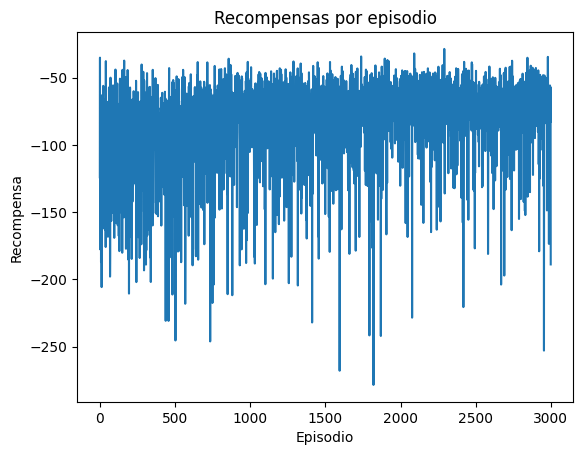

In [9]:
import matplotlib.pyplot as plt
plt.plot(rewards)
plt.xlabel('Episodio')
plt.ylabel('Recompensa')
plt.title('Recompensas por episodio')
plt.show()

In [10]:
test_rewards = agent.test_agent(env, episodes=500)
test_average_reward = np.mean(test_rewards)
print(f"Promedio de recompensas en test: {test_average_reward}")


Episode: 0, Reward: -78.42
Episode: 1, Reward: -63.48
Episode: 2, Reward: -77.78
Episode: 3, Reward: -56.70
Episode: 4, Reward: -72.15
Episode: 5, Reward: -49.66
Episode: 6, Reward: -59.71
Episode: 7, Reward: -77.74
Episode: 8, Reward: -57.12
Episode: 9, Reward: -57.23
Episode: 10, Reward: -56.36
Episode: 11, Reward: -62.03
Episode: 12, Reward: -67.33
Episode: 13, Reward: -49.69
Episode: 14, Reward: -65.68
Episode: 15, Reward: -58.88
Episode: 16, Reward: -56.12
Episode: 17, Reward: -54.65
Episode: 18, Reward: -73.67
Episode: 19, Reward: -66.84
Episode: 20, Reward: -54.65
Episode: 21, Reward: -48.33
Episode: 22, Reward: -65.71
Episode: 23, Reward: -63.15
Episode: 24, Reward: -57.22
Episode: 25, Reward: -54.62
Episode: 26, Reward: -46.84
Episode: 27, Reward: -49.78
Episode: 28, Reward: -51.87
Episode: 29, Reward: -48.72
Episode: 30, Reward: -48.07
Episode: 31, Reward: -68.77
Episode: 32, Reward: -48.33
Episode: 33, Reward: -72.44
Episode: 34, Reward: -55.93
Episode: 35, Reward: -46.01
Ep

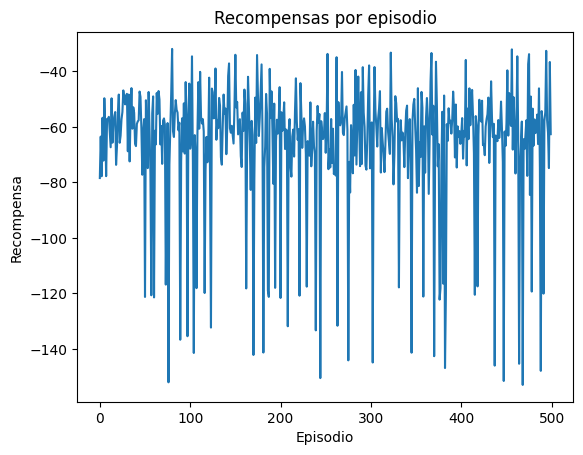

In [12]:
plt.plot(test_rewards)
plt.xlabel('Episodio')
plt.ylabel('Recompensa')
plt.title('Recompensas por episodio')
plt.show()

In [11]:
# Configuración de wandb
wandb.login(key="b1666b9050a5ade20a5130837a3c3c5ac2e39580")
wandb.init(project="descent_env_training", name="training_run")
# Guardar hiperparámetros
wandb.config.update({
    "epsilon": epsilon,
    "gamma": gamma,
    "alpha": alpha,
    "episodes": episodes,
    "altitude_space_start": altitude_space_start,
    "altitude_space_end": altitude_space_end,
    "altitude_space_num": altitude_space_num,
    "vertical_velocity_space_start": vertical_velocity_space_start,
    "vertical_velocity_space_end": vertical_velocity_space_end,
    "vertical_velocity_space_num": vertical_velocity_space_num,
    "target_altitude_space_start": target_altitude_space_start,
    "target_altitude_space_end": target_altitude_space_end,
    "target_altitude_space_num": target_altitude_space_num,
    "runway_distance_space_start": runway_distance_space_start,
    "runway_distance_space_end": runway_distance_space_end,
    "runway_distance_space_num": runway_distance_space_num
})

# Guardar discretización de los datos
wandb.log({
    "test_average_reward": test_average_reward
})
wandb.finish()

AttributeError: module 'wandb' has no attribute 'login'

In [ ]:
import umap.umap_ as umap
import numpy as np
import matplotlib.pyplot as plt

# Aplanar la tabla Q de 5 dimensiones a 2D para usar UMAP
q_table_flattened = agent.q.reshape(-1, agent.q.shape[-1])  # Combina todas las dimensiones excepto la última

# Reducir dimensiones con UMAP
reducer = umap.UMAP(n_components=2, random_state=42)
q_table_reduced = reducer.fit_transform(q_table_flattened)

# Visualizar los datos reducidos
plt.figure(figsize=(10, 8))
plt.scatter(q_table_reduced[:, 0], q_table_reduced[:, 1], c=np.max(q_table_flattened, axis=1), cmap='viridis', s=5)
plt.colorbar(label="Valor Q máximo")
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.title("Reducción de dimensiones de la tabla Q con UMAP")
plt.show()

ImportError: Numba needs NumPy 1.24 or greater. Got NumPy 1.23.

: 

In [ ]:
# Train the agent and visualize its execution
wrapper = VideoRecorderWrapper(env, filename='landing_execution.mp4', fps=3)
human_env = DescentEnv(render_mode='human')




Reading config from C:\Users\Agu\bluesky\settings.cfg
Reading magnetic variation data
Loading global navigation database...
Reading cache: C:\Users\Agu\bluesky\cache\navdata.p
Attempt to reimplement AREA from <bound method Area.set_area of <bluesky.plugins.area.Area object at 0x0000027AA113FFD0>> to <bound method Area.set_area of <bluesky.plugins.area.Area object at 0x0000027AA113FFD0>>
Attempt to reimplement EXP from <function init_plugin.<locals>.<lambda> at 0x0000027AD820FF40> to <function init_plugin.<locals>.<lambda> at 0x0000027AA5FDBAC0>
Attempt to reimplement TAXI from <bound method Area.set_taxi of <bluesky.plugins.area.Area object at 0x0000027AA113FFD0>> to <bound method Area.set_taxi of <bluesky.plugins.area.Area object at 0x0000027AA113FFD0>>
Successfully loaded plugin AREA
Attempt to reimplement DATAFEED from <bound method Modesbeast.toggle of <bluesky.plugins.adsbfeed.Modesbeast object at 0x0000027AA10D5A20>> to <bound method Modesbeast.toggle of <bluesky.plugins.adsbfeed